# Estimation bayésienne par copule : décrire des distributions jointes corrélées







## Le problème
Lorsque nous manipulons plusieurs variables (par exemple $a$ et $b$), nous cherchons souvent à décrire la distribution jointe $P(a, b)$ de manière paramétrique. Dans le meilleur des cas, cette distribution jointe peut être "simple" d'une certaine manière. Par exemple, si $a$ et $b$ sont statistiquement indépendantes, alors nous pouvons factoriser la loi jointe comme $P(a, b) = P(a) P(b)$, et il suffit alors de trouver des descriptions paramétriques appropriées pour $P(a)$ et $P(b)$. Même si ce n’est pas le cas, il se peut que $P(a, b)$ soit bien représentée par une distribution multivariée simple, comme une loi normale multivariée par exemple.

Cependant, dans de nombreux cas concrets, les jeux de données présentent une structure de corrélation complexe dans $P(a, b)$, ce qui rend les approches précédentes inadaptées. Des méthodes alternatives sont alors nécessaires.

## Les copules à la rescousse
C’est ici que les [copules](https://fr.wikipedia.org/wiki/Copule_(th%C3%A9orie_des_probabilit%C3%A9s)) interviennent. Elles permettent de décrire une distribution complexe $P(a, b)$ présentant une structure de dépendance via une distribution multivariée simple (comme une gaussienne multivariée), deux lois marginales, et quelques transformations. Pour une introduction accessible aux copules, je recommande ce [billet de blog](https://twiecki.io/blog/2018/05/03/copulas/) de Thomas Wiecki qui m'a beaucoup facilité la compréhension de cette notion abstraite.

Ce notebook montre comment décrire une distribution $P(a, b)$ avec structure de dépendance en utilisant des méthodes bayésiennes pour inférer les paramètres de la copule. L’approche générale est illustrée par le schéma ci-dessous :
- En bas, nous avons notre **espace d’observation**, où vivent les données.
- On suppose que ces données ont été générées selon un processus allant de haut en bas : une loi normale multivariée dans l’**espace gaussien multivarié** est transformée en deux étapes pour donner les données observées.
- Bien que nous n’ayons accès qu’aux données dans l’**espace d’observation**, nous pouvons faire de l’inférence sur les paramètres dans l’**espace gaussien multivarié** en effectuant les transformations inverses.


<img src="copulas.png" alt="schéma de copule" width="30%" heigh = "50%">

Schéma d’une copule gaussienne bidimensionnelle. La distribution complexe $P(a, b)$ dans l’espace d’observation (en bas) est modélisée comme étant générée par une copule gaussienne bidimensionnelle dans l’espace gaussien multivarié (en haut). Le passage de l’espace gaussien multivarié à l’espace d’observation (vers le bas) se fait via la fonction de répartition (FDR) de la loi normale, puis via les fonctions inverses des lois marginales. Le processus inverse d’inférence (vers le haut) s’effectue via la fonction de répartition des lois marginales, suivie de l’inverse de la fonction de répartition de la loi normale.



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import expon, multivariate_normal, norm


In [ ]:
# Amélioration du rendu des figures 
%config InlineBackend.figure_format = 'retina'


sns.set_style("darkgrid")  

# Configuration des paramètres globaux de matplotlib
plt.rcParams.update({
    "font.size": 14,
    "figure.constrained_layout.use": False
})


SEED = 43
rng = np.random.default_rng(SEED)


## Processus de génération des données

Avant de passer à l’inférence, nous allons d’abord détailler les étapes du schéma présenté plus haut.  
Dans un premier temps, nous allons démontrer le modèle génératif en décrivant une copule normale multivariée, puis en la transformant dans l’espace d’observation.  
Ensuite, nous montrerons comment les transformations inverses permettent de remonter de l’espace d’observation vers l’espace gaussien multivarié.  
Une fois ces éléments bien posés, nous pourrons aborder le processus d’inférence dans une section ultérieure.

Nous allons maintenant définir les propriétés de notre copule gaussienne via un dictionnaire imbriqué.  
Au niveau supérieur, ce dictionnaire contient les clés `a`, `b` et `rho`.

- `rho` représente le coefficient de corrélation de la copule normale multivariée.  
- `a` et `b` sont eux-mêmes des dictionnaires, contenant la loi marginale (sous forme d’objet `scipy.stats`) et ses paramètres.

Remarque : nous définissons implicitement la normale multivariée avec une espérance nulle et une variance unitaire.  



In [29]:
# Définition des propriétés de notre copule
b_scale = 2
θ = {
    "a_dist": norm(),                         # Loi marginale pour a : loi normale standard
    "b_dist": expon(scale=1 / b_scale),       # Loi marginale pour b : exponentielle
    "rho": 0.9                                # Corrélation dans la copule gaussienne
}


Tout d'abord, nous définissons la vraie loi normale multivariée et nous en échantillonnons quelques réalisations.


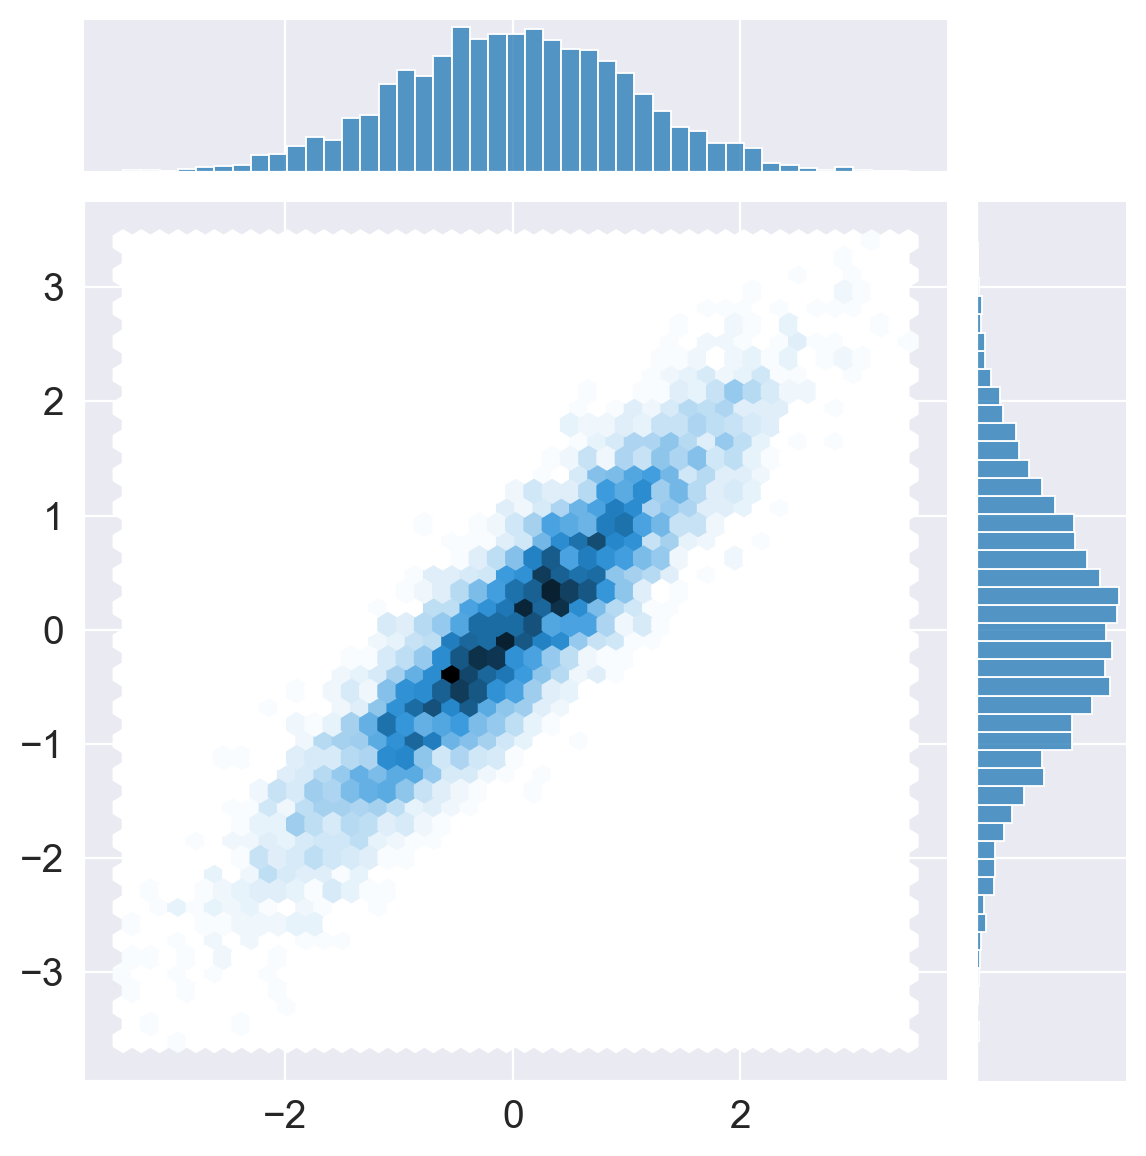

In [ ]:
n_samples = 5000

# Échantillonnage aléatoire dans l’espace normal multivarié
mu = [0, 0]
cov = [[1, θ["rho"]], [θ["rho"], 1]]
x = multivariate_normal(mu, cov).rvs(n_samples, random_state=rng)

a_norm = x[:, 0]
b_norm = x[:, 1]

# Visualisation conjointe 
sns.jointplot(x=a_norm, y=b_norm, height=6, kind="hex")


Notre première transformation (la fonction de répartition normale) permet de passer de l’espace normal multivarié à l’espace uniforme.  
On observe que les lois marginales deviennent uniformes, mais que la structure de dépendance issue de l’espace normal multivarié est préservée dans la densité conjointe.


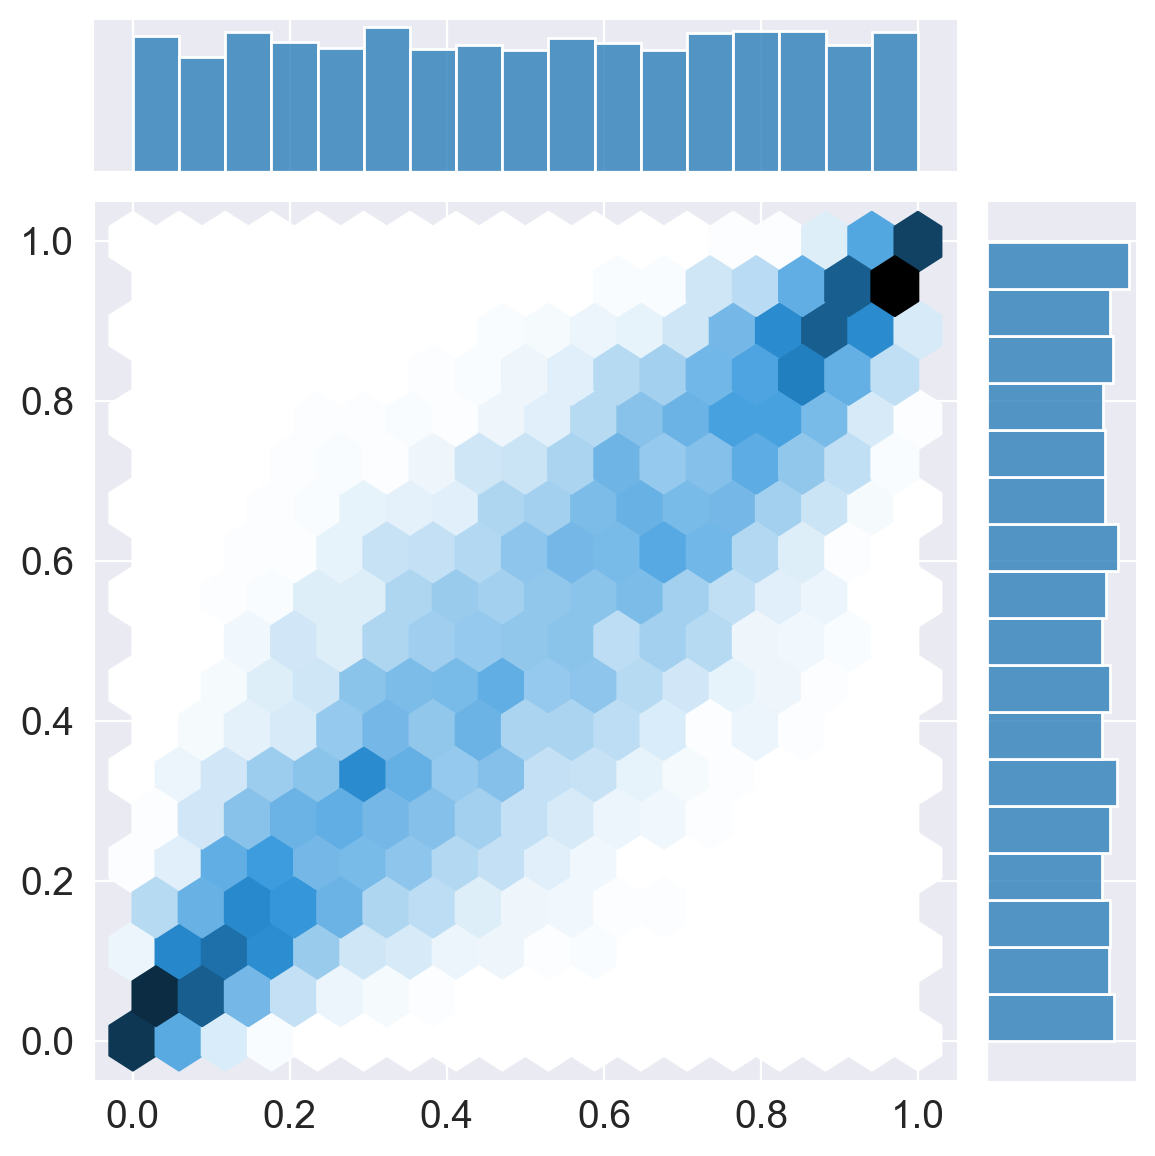

In [31]:
# Transformation vers l’espace uniforme via la CDF de la loi normale standard
a_unif = norm(loc=0, scale=1).cdf(a_norm)
b_unif = norm(loc=0, scale=1).cdf(b_norm)

# Visualisation : marges uniformes mais dépendance conservée
sns.jointplot(x=a_unif, y=b_unif, height=6, kind="hex")


Notre dernière transformation (l'inverse des fonctions de répartition marginales) permet d’obtenir $a$ et $b$ dans l’espace d’observation.


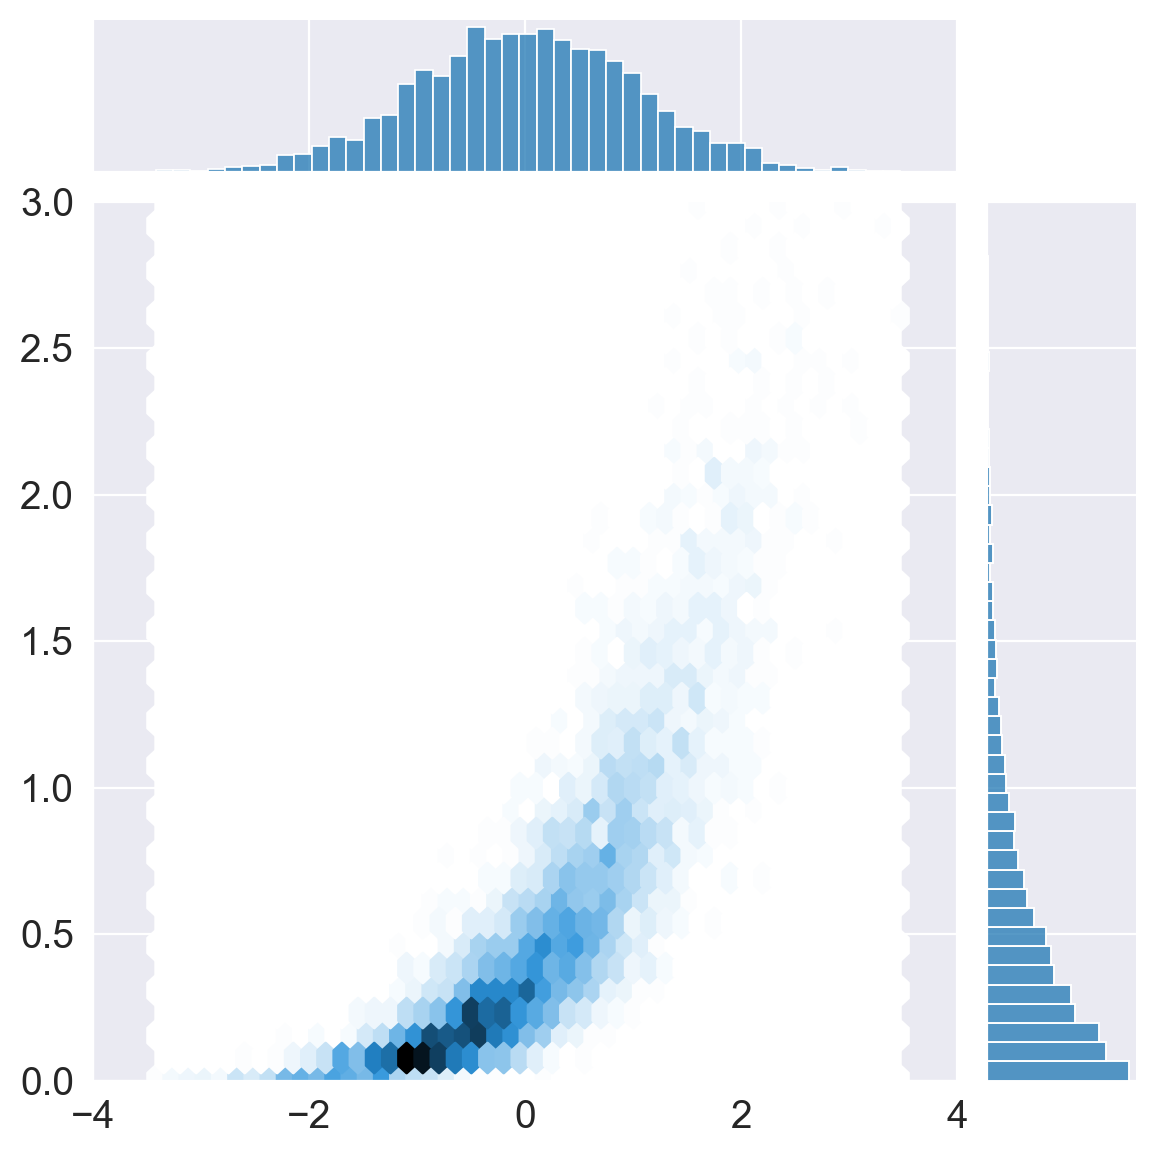

In [32]:
# Transformation vers l’espace d’observation via les inverses des CDF marginales (PPF)
a = θ["a_dist"].ppf(a_unif)
b = θ["b_dist"].ppf(b_unif)

# Visualisation dans l’espace d’observation
sns.jointplot(x=a, y=b, height=6, kind="hex", xlim=(-4, 4), ylim=(0, 3))


## Processus d’inférence par copule

Pour bien comprendre l’approche utilisée, nous allons dérouler le processus inverse : remonter de l’espace d’observation vers l’espace gaussien multivarié.


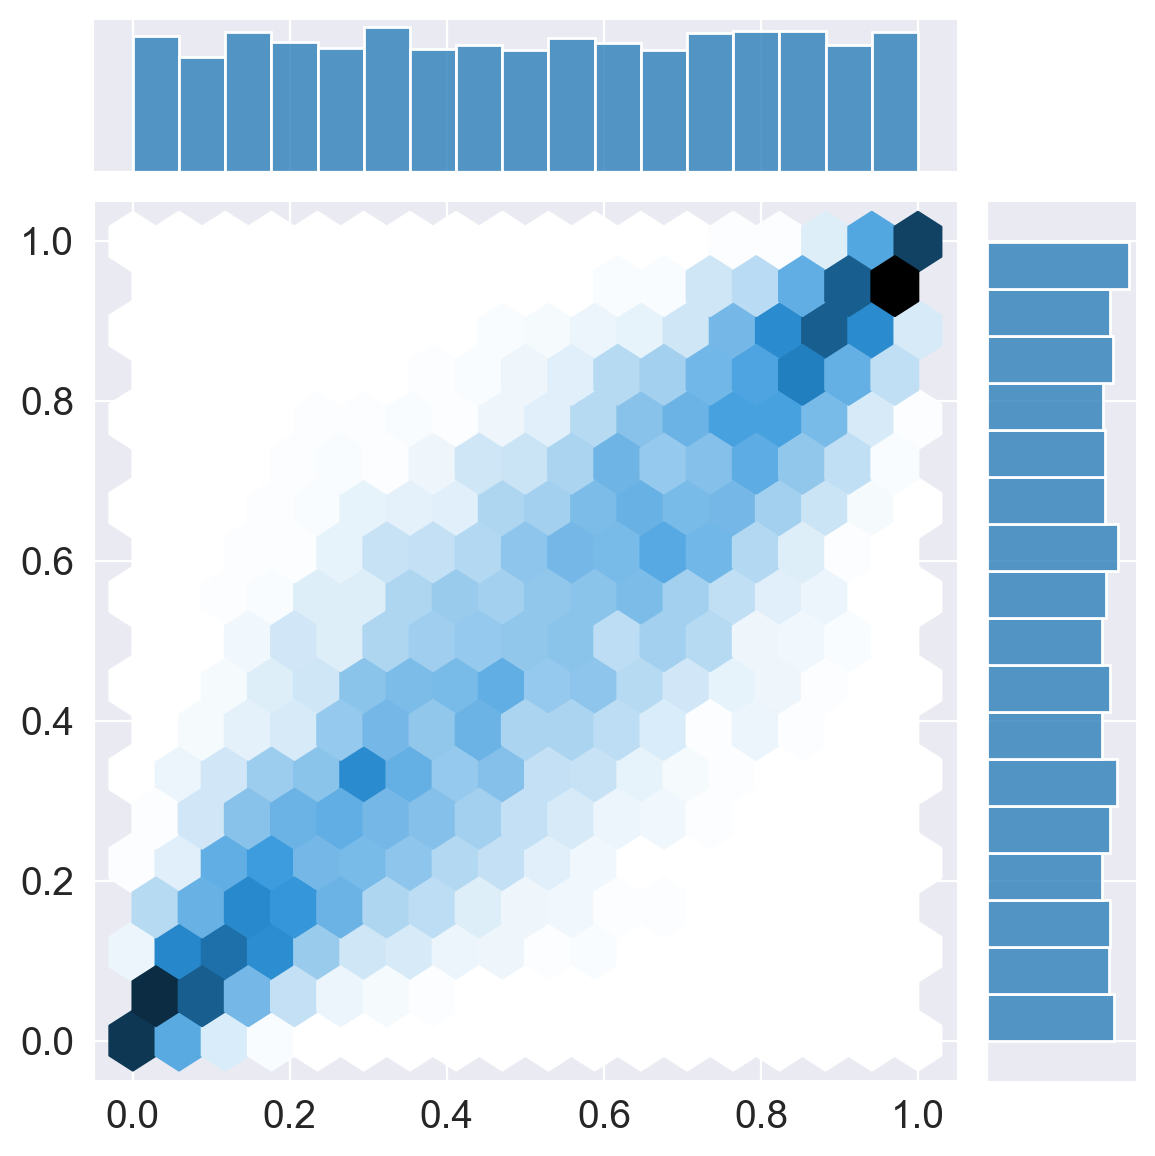

In [33]:
# Transformation de l’espace d’observation vers l’espace uniforme via les CDF marginales
a1 = θ["a_dist"].cdf(a)
b1 = θ["b_dist"].cdf(b)

# Visualisation des données transformées (marges uniformes)
sns.jointplot(x=a1, y=b1, kind="hex", height=6)


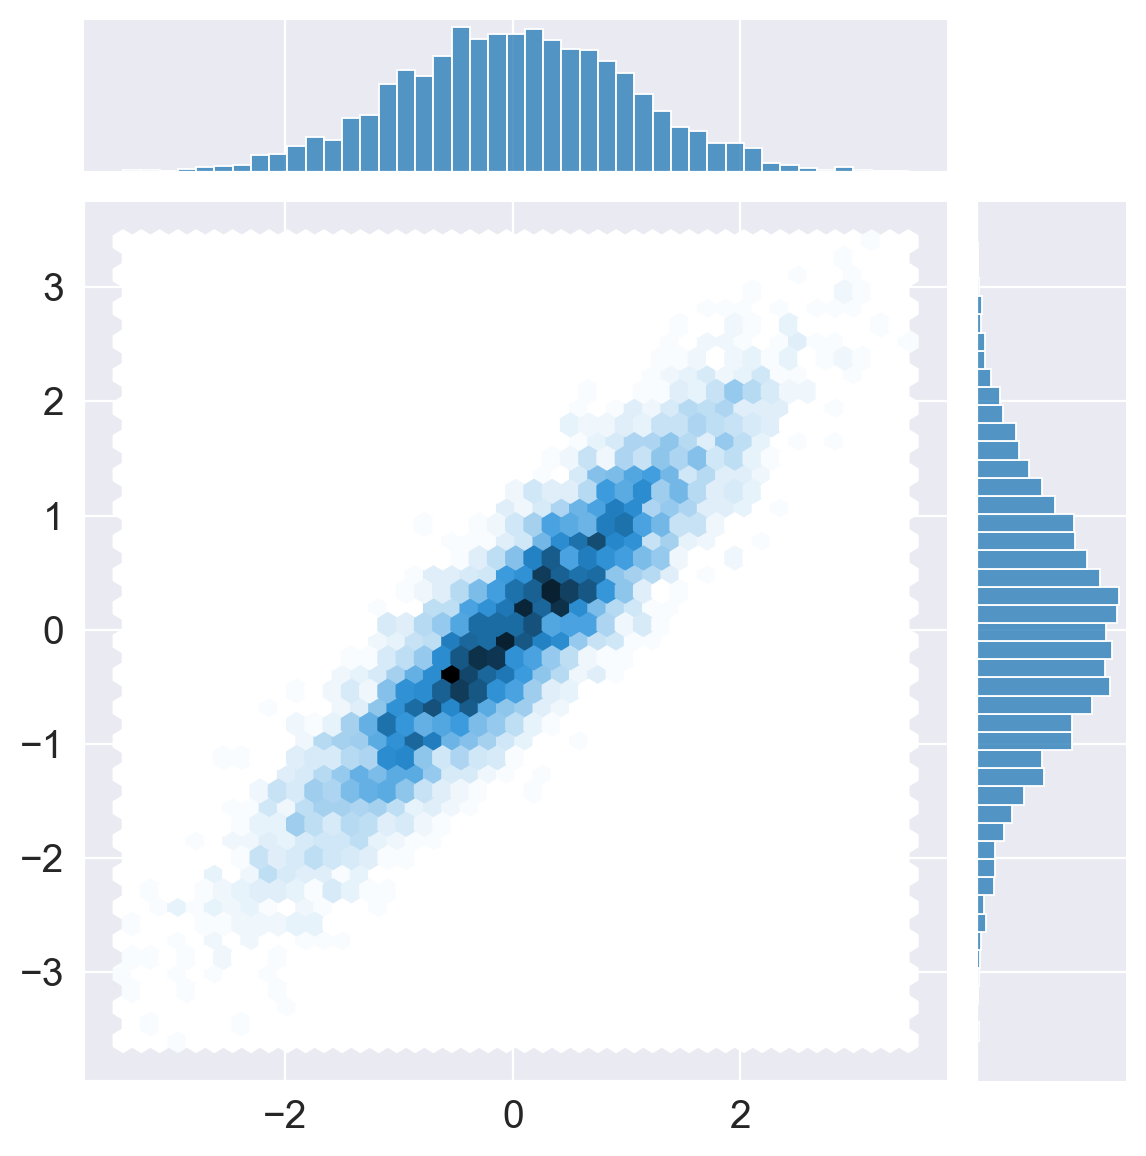

In [34]:
# Transformation de l’espace uniforme vers l’espace gaussien multivarié via l’inverse de la CDF normale
a2 = norm(loc=0, scale=1).ppf(a1)
b2 = norm(loc=0, scale=1).ppf(b1)

# Visualisation dans l’espace latent gaussien reconstruit
sns.jointplot(x=a2, y=b2, kind="hex", height=6)


Nous avons désormais parcouru en détail toutes les étapes présentées dans la Figure 1.  
Nous avons décrit précisément le processus de génération des données, allant de l’espace normal multivarié jusqu’à l’espace d’observation.  
Nous avons ensuite vu comment effectuer le processus inverse (l’inférence), c’est-à-dire remonter de l’espace d’observation vers l’espace gaussien multivarié.

C’est cette approche conceptuelle que nous allons reproduire dans le modèle d’estimation.


## Modèles pour l’estimation des copules et des marges

Nous souhaitons réaliser l’inférence des paramètres dans l’espace gaussien multivarié, en contraignant les valeurs plausibles de ces paramètres à partir des données observées dans l’espace d’observation.  
Cependant, nos observations sur $a$ et $b$ permettent également d’estimer les paramètres des lois marginales.

Lors de nos expérimentations, nous avons testé des modèles réalisant une estimation **conjointe** :
- des paramètres des lois marginales,
- et du paramètre de corrélation de la copule.

Mais cette approche conjointe s’est révélée **instable**.

La solution retenue, plus robuste, repose sur un processus en **deux étapes** :

1. Estimer les paramètres des lois marginales.  
2. Estimer le paramètre de covariance de la copule, en utilisant les **estimations ponctuelles** des marges obtenues à l’étape 1.


In [35]:
from scipy.optimize import minimize
from scipy.stats import norm, expon

# Étape 1 : Estimation des paramètres des lois marginales (a ~ Normale, b ~ Exponentielle)

# -------- Estimation pour a (loi normale) -------- #
def neg_log_likelihood_norm(params, data):
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    return -np.sum(norm.logpdf(data, loc=mu, scale=sigma))

res_a = minimize(
    fun=neg_log_likelihood_norm,
    x0=[0.0, 1.0],  # initial guess: mu=0, sigma=1
    args=(a,),
    bounds=[(None, None), (1e-6, None)]  # sigma > 0
)

a_mu_mle, a_sigma_mle = res_a.x

# -------- Estimation pour b (loi exponentielle) -------- #
def neg_log_likelihood_expon(scale, data):
    if scale <= 0:
        return np.inf
    return -np.sum(expon.logpdf(data, scale=scale))

res_b = minimize(
    fun=neg_log_likelihood_expon,
    x0=[1.0],  # initial guess
    args=(b,),
    bounds=[(1e-6, None)]  # scale > 0
)

b_scale_mle = res_b.x[0]

# Affichage des résultats
print(f"Paramètres estimés pour a : mu = {a_mu_mle:.4f}, sigma = {a_sigma_mle:.4f}")
print(f"Paramètre estimé pour b : scale = {b_scale_mle:.4f}")


Paramètres estimés pour a : mu = 0.0135, sigma = 1.0098
Paramètre estimé pour b : scale = 0.5102


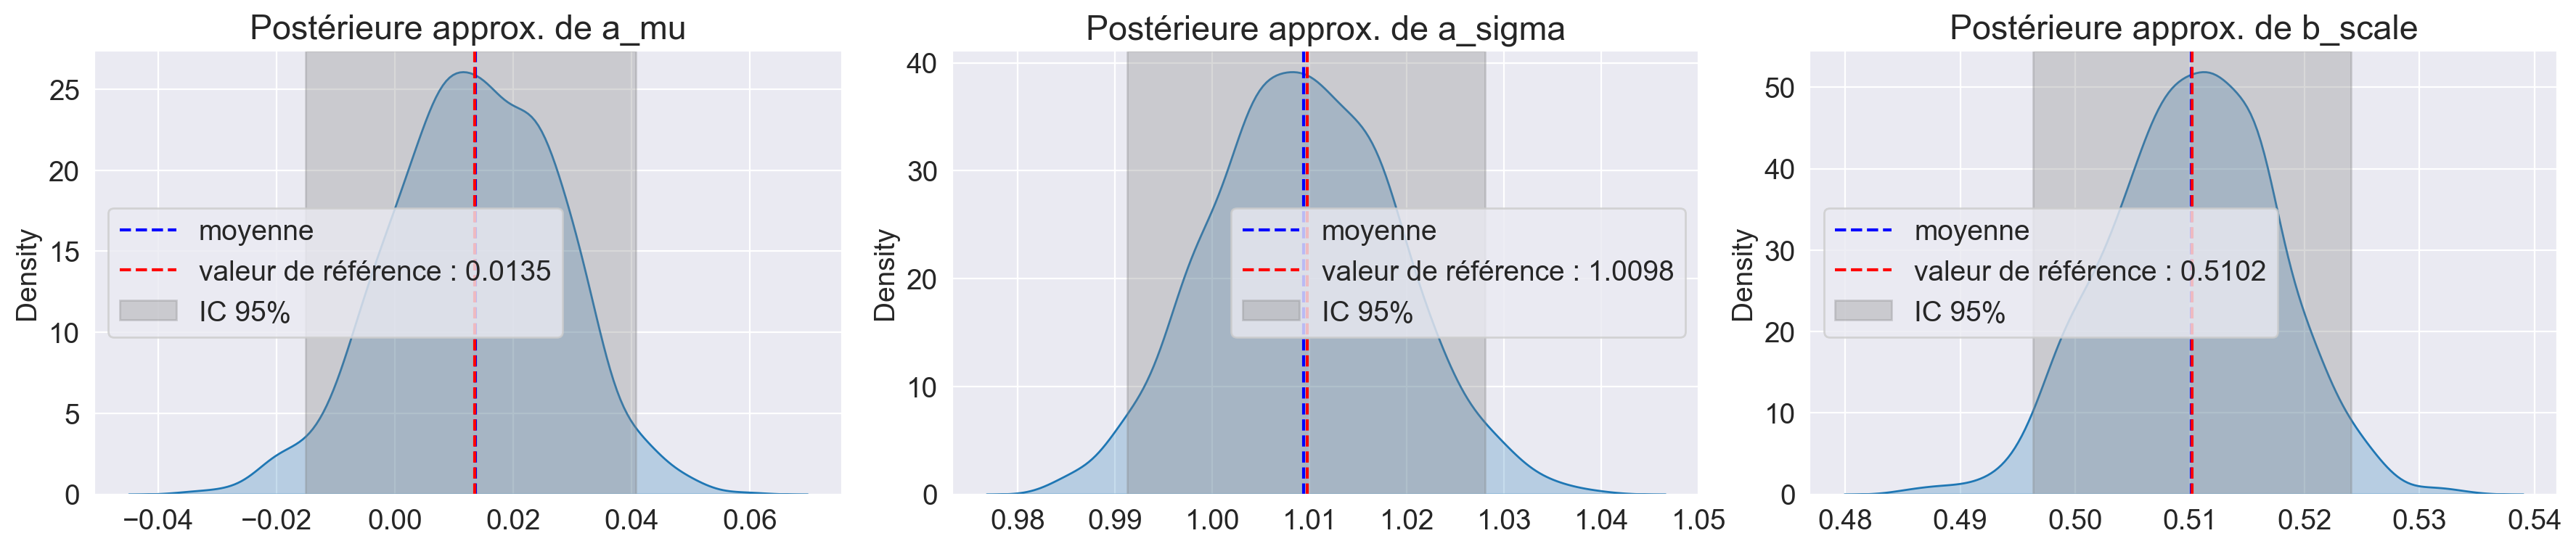

In [36]:
from scipy.stats import bootstrap

# Fonction utilitaire pour obtenir les paramètres
def estimate_marginals(data_a, data_b):
    res_a = minimize(neg_log_likelihood_norm, x0=[0.0, 1.0], args=(data_a,), bounds=[(None, None), (1e-6, None)])
    res_b = minimize(neg_log_likelihood_expon, x0=[1.0], args=(data_b,), bounds=[(1e-6, None)])
    return res_a.x[0], res_a.x[1], res_b.x[0]  # a_mu, a_sigma, b_scale

# Bootstrap sur 1000 échantillons
n_boot = 1000
a_mu_samples = []
a_sigma_samples = []
b_scale_samples = []

for _ in range(n_boot):
    idx = rng.choice(len(a), size=len(a), replace=True)
    a_mu_i, a_sigma_i, b_scale_i = estimate_marginals(a[idx], b[idx])
    a_mu_samples.append(a_mu_i)
    a_sigma_samples.append(a_sigma_i)
    b_scale_samples.append(b_scale_i)

# Convertir en arrays numpy
a_mu_samples = np.array(a_mu_samples)
a_sigma_samples = np.array(a_sigma_samples)
b_scale_samples = np.array(b_scale_samples)

# Tracer l’équivalent de plot_posterior
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
params = {
    "a_mu": (a_mu_samples, 0.0135),
    "a_sigma": (a_sigma_samples, 1.0098),
    "b_scale": (b_scale_samples, 0.5102)
}

for ax, (name, (samples, ref)) in zip(axes, params.items()):
    sns.kdeplot(samples, ax=ax, fill=True)
    ax.axvline(np.mean(samples), color="blue", linestyle="--", label="moyenne")
    ax.axvline(ref, color="red", linestyle="--", label=f"valeur de référence : {ref}")
    hdi_low = np.percentile(samples, 2.5)
    hdi_high = np.percentile(samples, 97.5)
    ax.axvspan(hdi_low, hdi_high, color="gray", alpha=0.3, label=f"IC 95%")
    ax.set_title(f"Postérieure approx. de {name}")
    ax.legend()

plt.tight_layout()
plt.show()


## Estimation du paramètre de dépendance

L’objectif est d’estimer $\rho$, le paramètre de dépendance de la copule gaussienne, à partir des données observées $(a, b)$.

### Méthode adoptée

1. **Estimation ponctuelle des paramètres marginaux** (MLE).
2. **Transformation des données dans l’espace latent** :
   - $a \to u_a = F_a(a)$, $b \to u_b = F_b(b)$,
   - $u_a, u_b \to z_a, z_b$ via $\Phi^{-1}$ (CDF normale inverse).
3. **Estimation de $\rho$** à partir des paires $(z_a, z_b)$ par maximum de vraisemblance.

### Justification du choix

- **Simplification** : pas de propagation d’incertitude sur les marges.
- **Stabilité numérique** : les estimations sont plus robustes que les approches intégrant toute la postérieure.
- **Séparation claire des étapes** : marges d’abord, dépendance ensuite.

Ce choix est fréquentiste et pragmatique, mais il **ignore l’incertitude sur les marges**.


In [ ]:
import numpy as np
from scipy.stats import expon, multivariate_normal

# --- Données supposées connues
# data : array de forme (n, 2)
assert data.shape[1] == 2
n = data.shape[0]

# --- Log-prior sur la corrélation (LKJ pour dimension 2)
def log_prior_rho(rho, eta=2.0):
    if not -1 < rho < 1:
        return -np.inf
    return (eta - 1) * np.log(1 - rho**2)

# --- Log-prior sur les écart-types s1, s2 ~ Exp(1.0)
def log_prior_std(s):
    return expon(scale=1.0).logpdf(s) if s > 0 else -np.inf

# --- Log-vraisemblance gaussienne
def log_likelihood(data, s1, s2, rho):
    try:
        L = np.array([
            [s1, 0],
            [rho * s2, s2 * np.sqrt(1 - rho**2)]
        ])
        cov = L @ L.T
        return np.sum(multivariate_normal(mean=[0, 0], cov=cov).logpdf(data))
    except np.linalg.LinAlgError:
        return -np.inf

# --- Log-postérieur complet
def log_posterior(s1, s2, rho, data, eta=2.0):
    return (
        log_prior_std(s1)
        + log_prior_std(s2)
        + log_prior_rho(rho, eta)
        + log_likelihood(data, s1, s2, rho)
    )

# --- Sampler Metropolis-Hastings
def metropolis_sampler(data, n_iter=10000, burn=2000, thin=5, eta=2.0):
    samples = []
    s1, s2, rho = 1.0, 1.0, 0.5
    current_lp = log_posterior(s1, s2, rho, data, eta)

    for i in range(n_iter):
        s1_p = abs(s1 + np.random.normal(0, 0.1))
        s2_p = abs(s2 + np.random.normal(0, 0.1))
        rho_p = np.clip(rho + np.random.normal(0, 0.05), -0.999, 0.999)

        prop_lp = log_posterior(s1_p, s2_p, rho_p, data, eta)
        accept_ratio = np.exp(prop_lp - current_lp)

        if np.random.rand() < accept_ratio:
            s1, s2, rho = s1_p, s2_p, rho_p
            current_lp = prop_lp

        if i >= burn and i % thin == 0:
            samples.append([s1, s2, rho])

    return np.array(samples)

# Appel
samples = metropolis_sampler(data, n_iter=20000, burn=5000, thin=10)
s1_samples, s2_samples, rho_samples = samples[:, 0], samples[:, 1], samples[:, 2]


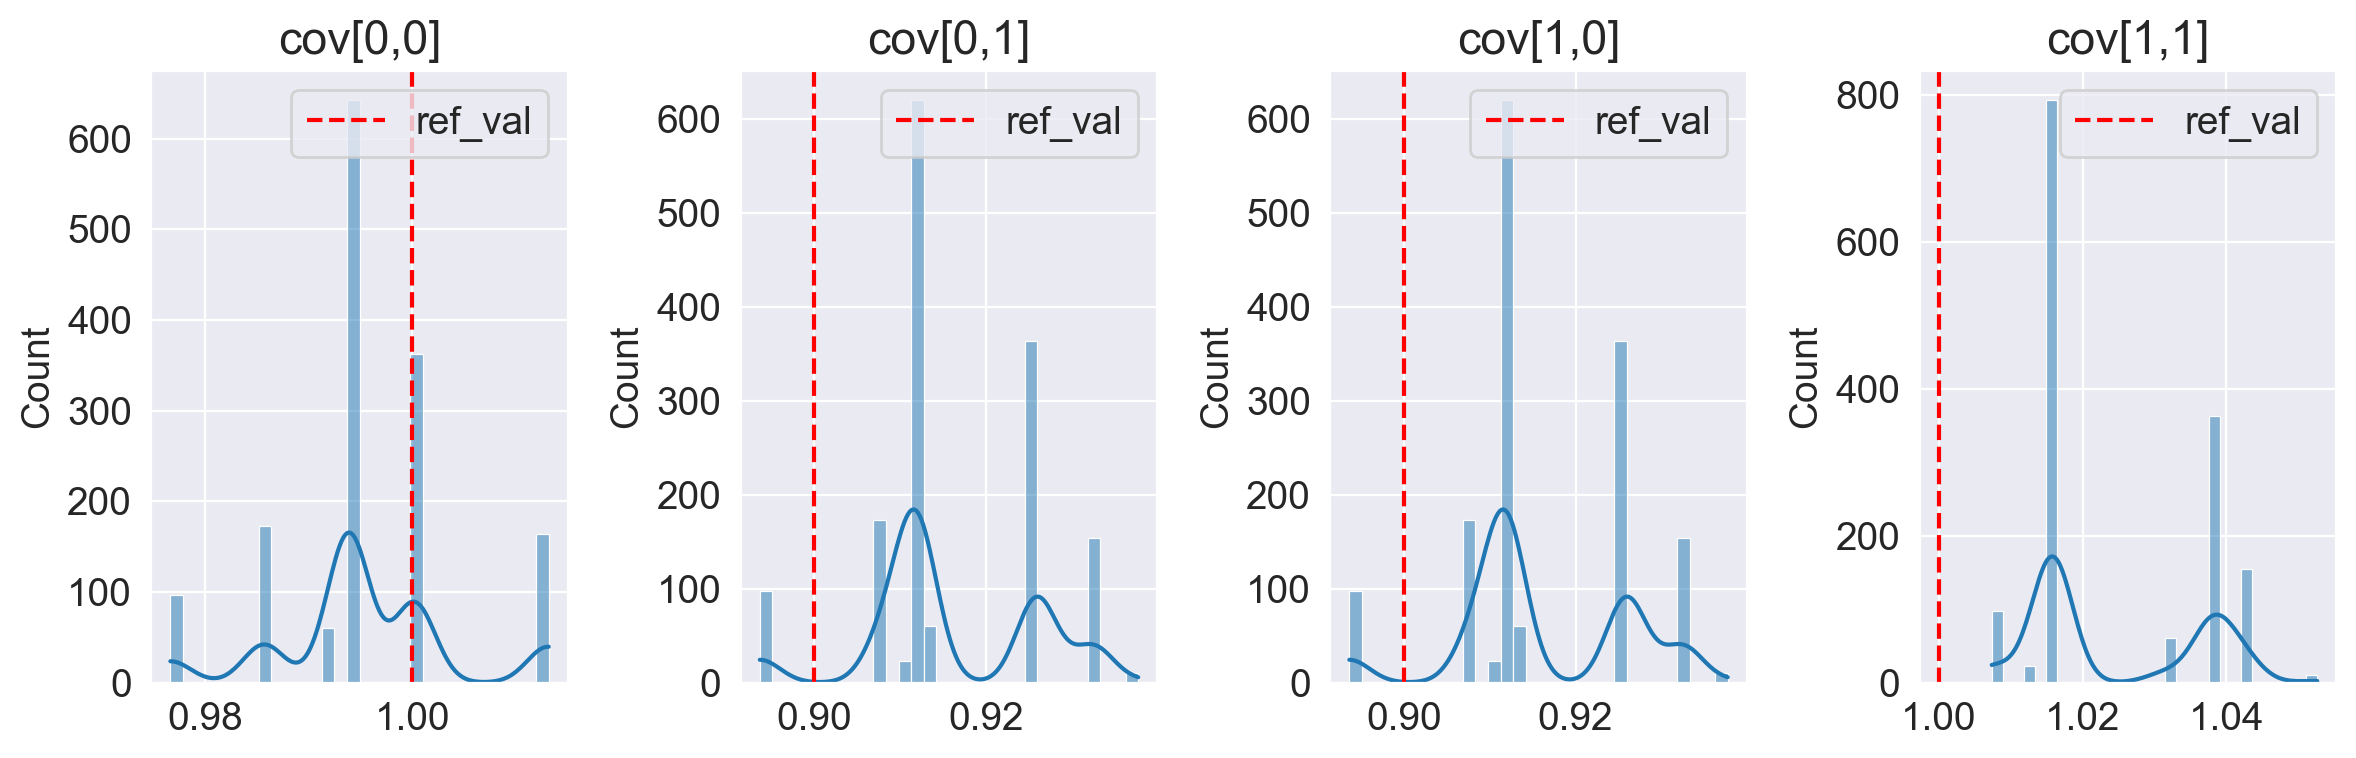

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon, multivariate_normal

# Données  connues
# data : array (n, 2)
# θ["rho"] : valeur théorique de rho


assert data.shape[1] == 2
n = data.shape[0]


    

# Sampler
def sample_covariance_posterior(data, n_iter=20000, burn=5000, thin=10, seed=42):
    rng = np.random.default_rng(seed)
    s1, s2, rho = 1.0, 1.0, 0.5
    current_lp = log_posterior(s1, s2, rho, data)
    samples = []

    for i in range(n_iter):
        s1_p = abs(s1 + rng.normal(0, 0.1))
        s2_p = abs(s2 + rng.normal(0, 0.1))
        rho_p = np.clip(rho + rng.normal(0, 0.05), -0.999, 0.999)

        proposed_lp = log_posterior(s1_p, s2_p, rho_p, data)
        accept_prob = np.exp(proposed_lp - current_lp)

        if rng.uniform() < accept_prob:
            s1, s2, rho = s1_p, s2_p, rho_p
            current_lp = proposed_lp

        if i >= burn and i % thin == 0:
            L = np.array([
                [s1, 0],
                [rho * s2, s2 * np.sqrt(1 - rho**2)]
            ])
            cov = L @ L.T
            samples.append(cov)

    return np.array(samples)

# Exécution
cov_samples = sample_covariance_posterior(data, seed=rng.integers(0, 1e6))

# Extraction des composantes
cov_00 = cov_samples[:, 0, 0]
cov_01 = cov_samples[:, 0, 1]
cov_10 = cov_samples[:, 1, 0]
cov_11 = cov_samples[:, 1, 1]

# Valeurs de référence
ref_val = [1.0, θ["rho"], θ["rho"], 1.0]

# --- Tracés des 4 distributions postérieures  ---
plt.figure(figsize=(12, 4))

for i, (samples, label, ref) in enumerate(zip(
    [cov_00, cov_01, cov_10, cov_11],
    ["cov[0,0]", "cov[0,1]", "cov[1,0]", "cov[1,1]"],
    ref_val
)):
    plt.subplot(1, 4, i+1)
    sns.histplot(samples, kde=True, bins=30)
    plt.axvline(ref, color='r', linestyle='--', label="ref_val")
    plt.title(label)
    plt.legend()

plt.tight_layout()
plt.show()


Nous avons donc **récupéré avec succès** la matrice de covariance de la copule normale multivariée qui a servi à générer les données simulées.

Dans la section suivante, nous utiliserons cette information pour **échantillonner à partir de notre description paramétrique de** $P(a, b)$.


## Comparaison des inférences avec les données réelles

Enfin, nous pouvons effectuer une **vérification visuelle** afin de voir si nos inférences (en rouge) correspondent bien à nos données observées originales (en noir).


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal, norm, expon



# 1) Générer des échantillons (a_norm, b_norm) dans l’espace gaussien avec chaque matrice de covariance
rng = np.random.default_rng(43)
ab = np.vstack([
    multivariate_normal(mean=[0, 0], cov=cov).rvs(random_state=rng)
    for cov in cov_samples
])

# 2) Espace gaussien -> espace uniforme
uniform_a = norm().cdf(ab[:, 0])
uniform_b = norm().cdf(ab[:, 1])

# 3) Espace uniforme -> espace d’observation (via les PPF marginales)
ppc_a = norm(loc=a_mu, scale=a_sigma).ppf(uniform_a)
ppc_b = expon(scale=b_scale).ppf(uniform_b)


c:\Users\moi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(
c:\Users\moi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(


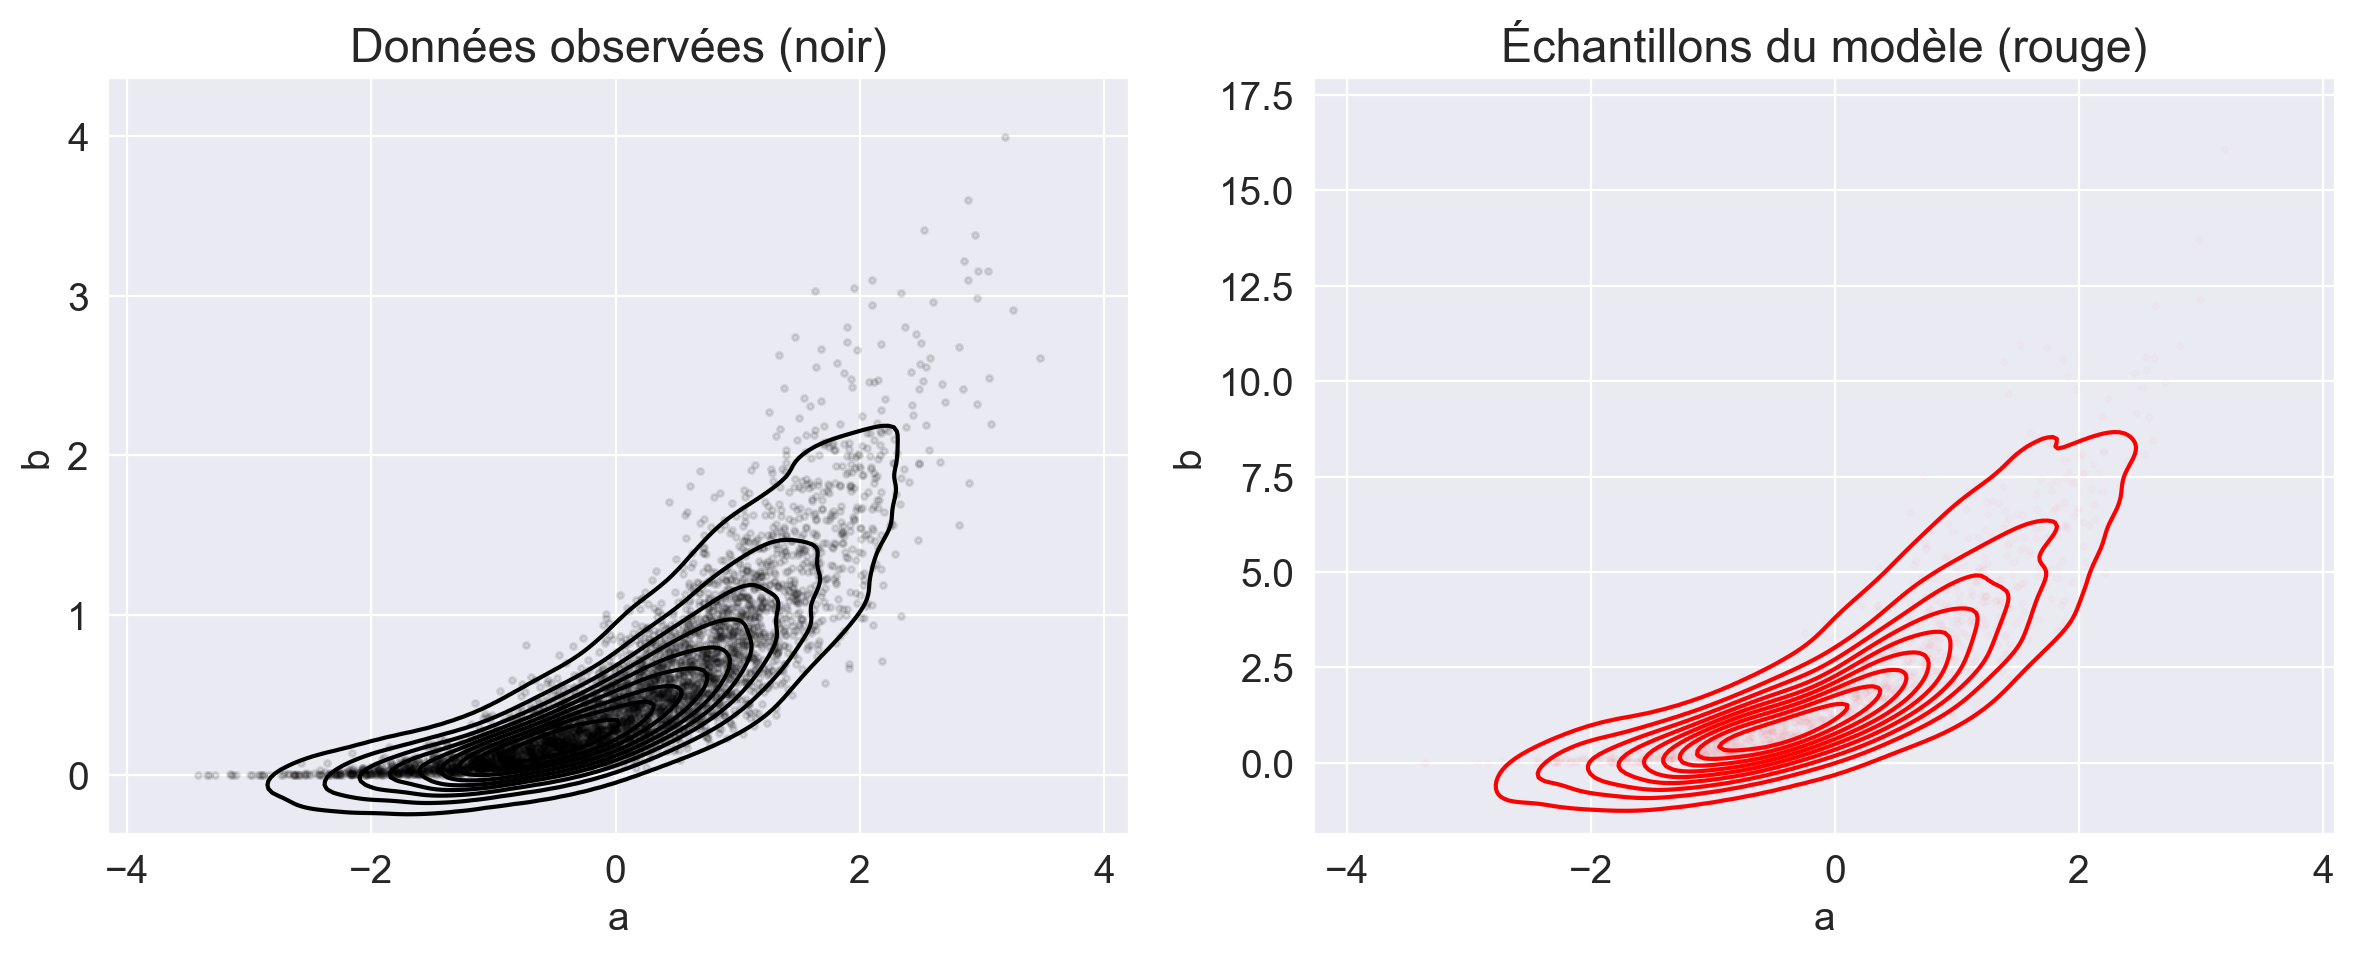

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- a, b : données observées
# ---- ppc_a, ppc_b : données simulées à partir du modèle bayésien

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) Nuage de points (scatter) + densité contours pour les données observées (noir)
sns.kdeplot(
    x=a, y=b,
    fill=False, levels=10, color="k", linestyle="--",
    ax=axes[0]
)
axes[0].scatter(a, b, alpha=0.1, color="k", s=5)
axes[0].set_title("Données observées (noir)")

# 2) Nuage de points (scatter) + densité contours pour les données simulées (rouge)
sns.kdeplot(
    x=ppc_a, y=ppc_b,
    fill=False, levels=10, color="r", linestyle="-",
    ax=axes[1]
)
axes[1].scatter(ppc_a, ppc_b, alpha=0.01, color="r", s=5)
axes[1].set_title("Échantillons du modèle (rouge)")

for ax in axes:
    ax.set_xlabel("a")
    ax.set_ylabel("b")

plt.tight_layout()
plt.show()


c:\Users\moi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(
c:\Users\moi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(


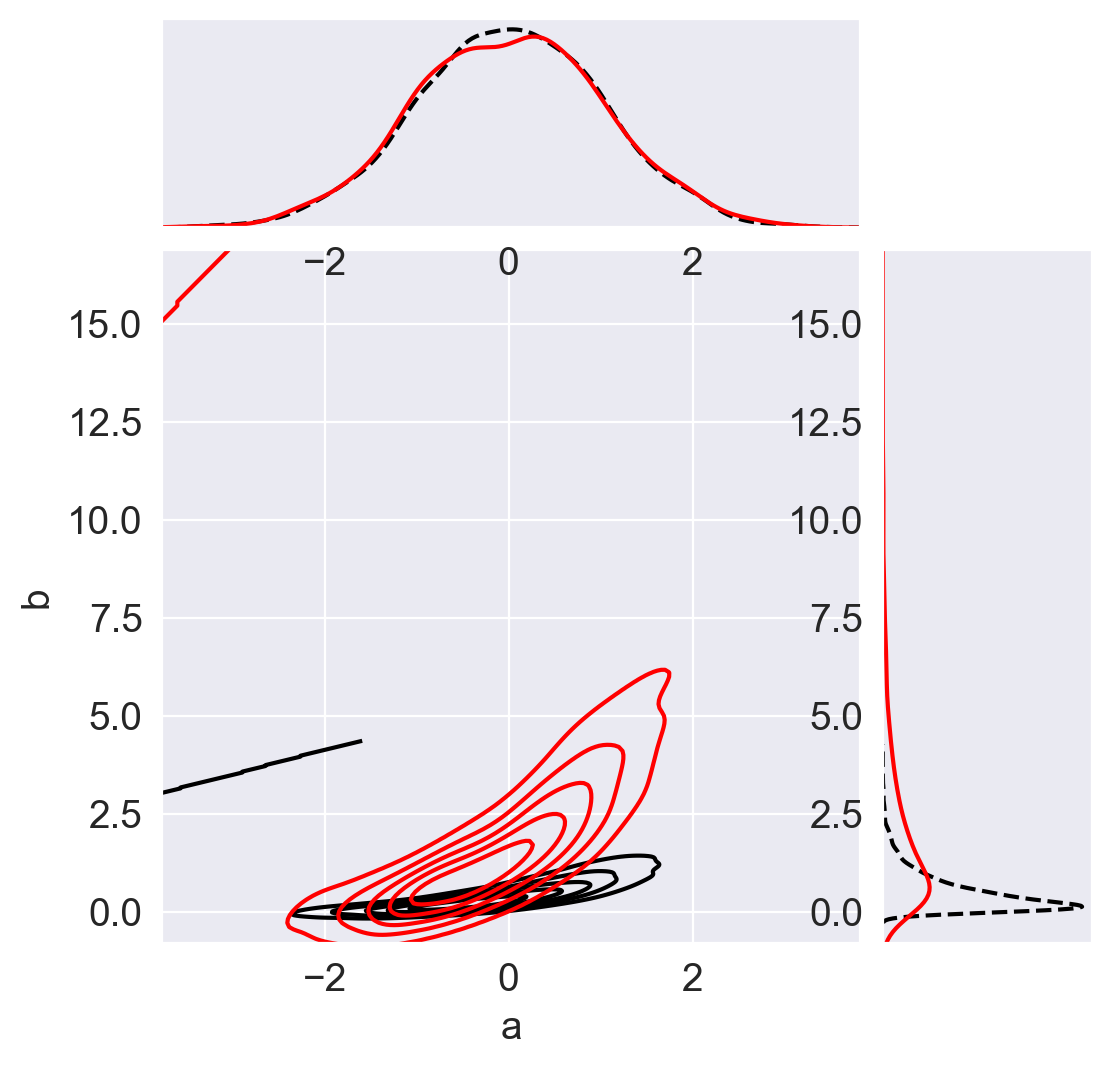

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Entrées attendues : a, b (observés) et ppc_a, ppc_b (modèle)
# a, b, ppc_a, ppc_b = ...


x_all = np.concatenate([a, ppc_a])
y_all = np.concatenate([b, ppc_b])
x_pad = 0.05 * (x_all.max() - x_all.min())
y_pad = 0.05 * (y_all.max() - y_all.min())
xlim = (x_all.min() - x_pad, x_all.max() + x_pad)
ylim = (y_all.min() - y_pad, y_all.max() + y_pad)

# Grille type pair-plot (joint + marges)
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(
    2, 2, width_ratios=(4, 1.2), height_ratios=(1.2, 4),
    wspace=0.05, hspace=0.05
)
ax_joint  = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# --- JOINT: contours KDE superposés ---
sns.kdeplot(x=a,     y=b,     levels=7, thresh=0.0, fill=False,
            color="k", linestyle="--", ax=ax_joint)
sns.kdeplot(x=ppc_a, y=ppc_b, levels=7, thresh=0.0, fill=False,
            color="r", linestyle="-",  ax=ax_joint)

ax_joint.set_xlim(xlim); ax_joint.set_ylim(ylim)
ax_joint.set_xlabel("a"); ax_joint.set_ylabel("b")

# --- MARGE X (haut) ---
sns.kdeplot(x=a,     color="k", linestyle="--", ax=ax_marg_x)
sns.kdeplot(x=ppc_a, color="r", linestyle="-",  ax=ax_marg_x)
ax_marg_x.set_ylabel("")
ax_marg_x.set_yticks([])
ax_marg_x.set_xlabel("")
ax_marg_x.grid(False)

# --- MARGE Y (droite) ---
sns.kdeplot(y=b,     color="k", linestyle="--", ax=ax_marg_y)
sns.kdeplot(y=ppc_b, color="r", linestyle="-",  ax=ax_marg_y)
ax_marg_y.set_xlabel("")
ax_marg_y.set_xticks([])
ax_marg_y.set_ylabel("")
ax_marg_y.grid(False)


for ax in (ax_joint, ax_marg_x, ax_marg_y):
    for spine in ax.spines.values():
        spine.set_visible(True)

plt.show()


**Référence**  
**Eric Ma** & **Benjamin T. Vincent**, November 2023 (*pymc-examples#257*).
